In [1]:
import logging
import os
import sys

# Add working dir to path
sys.path.insert(0,os.environ['PWD'])

logging.basicConfig()
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.DEBUG)

LOG = logging.getLogger(__name__)

In [14]:
import itertools
import hashlib
import logging
import os
import ssl
import time


import aiohttp
import asyncio

from contextlib import asynccontextmanager

from krill_api import KrillApiClient
from krill_api.models import KrillApiError

ImportError: cannot import name 'KrillApiError' from 'krill_api.models' (/Users/tdekock/src/ripe/rpki/testing/krill-status/krill_api/models.py)

In [ ]:
TOKEN = os.environ['KRILL_TOKEN']
KRILL_URL = os.environ['KRILL_URL']
KRILL_CERT_PATH = os.environ['KRILL_CERT_PATH']

# Dump the certificate in DER format like
# > openssl s_client -showcerts \
#     -servername krill.host \
#     -connect krill.host:3000 2>/dev/null | openssl x509 -inform pem -outform DER -out {KRILL_CERT_PATH}.der
#


with open(KRILL_CERT_PATH, 'rb') as f:
    digest = hashlib.sha256(f.read()).digest()
    
logging.basicConfig()
LOG = logging.getLogger(__name__)

In [ ]:
async with aiohttp.ClientSession(headers={'Authorization': f"Bearer {TOKEN}", "Accept": "application/json"}) as session:
    async with session.get(KRILL_URL + "/stats/info", ssl=aiohttp.Fingerprint(digest)) as r:
        json_body = await r.json()
        print(json_body)

In [15]:
async with KrillApiClient(KRILL_URL, TOKEN, aiohttp.Fingerprint(digest)) as client:
    print(await client.info())


KrillStatusInfo(version='0.12.0', started=1669969880)


In [16]:
"""
Get the status of all krill CAs
"""
async with KrillApiClient(KRILL_URL, TOKEN, aiohttp.Fingerprint(digest)) as client:
    t0 = time.time()

    res = await client.list()
    
    t1 = time.time()
    
    status_lists = await asyncio.gather(*[
        client.ca_parent_status(r.handle)
        for r in res
    ])
    
    t2 = time.time()
    statuses = list(itertools.chain.from_iterable(status_lists))
    
LOG.info(f"Loaded a list of %d CAs in %.3fs. Loaded %d CA parent details in %.3fs", len(res), t1-t0, len(status_lists), t2-t1)

INFO:__main__:Loaded a list of 279 CAs in 0.430s. Loaded 279 CA parent details in 8.262s


In [17]:
"""
Delete CAs with failing parent communication
"""
async with KrillApiClient(KRILL_URL, TOKEN, aiohttp.Fingerprint(digest)) as client:
    for s in statuses:
        if s.last_exchange.result != 'Success':
            LOG.info("Deleting CA %s because of parrent communication status %s", s.handle, s.last_exchange)
            LOG.info("result: %s", await client.ca_delete(s.handle))

In [18]:
import pandas as pd

In [19]:
now = time.time()
df = pd.DataFrame([{'rel_last_exchange': now - s.last_exchange.timestamp, 'rel_last_success': now - s.last_success, 'handle': s.handle} for s in statuses])
# No need to have long dataframe when using `df.plot.hist`, needed for `df.plot.hist(bins=20, by='variable')`
#df = pd.melt(df, id_vars=['handle'], value_vars=['last_exchange', 'last_success'])

df

,rel_last_exchange,rel_last_success,handle
0,55975.199161,55975.199161,krill_publisher_674190894927
1,94655.199161,94655.199161,krill-testbed-cloud
2,14639.199161,14639.199161,krill_publisher_603985408889
3,1830.199161,1830.199161,krill_publisher_809090195649
4,87121.199161,87121.199161,krill_publisher_435587410369
...,...,...,...
274,25274.199161,25274.199161,krill_publisher_378089449302
275,96207.199161,96207.199161,krill_publisher_556491294620
276,5895.199161,5895.199161,krill_publisher_519703114561
277,21144.199161,21144.199161,krill_publisher_634900463955


<AxesSubplot: ylabel='Frequency'>

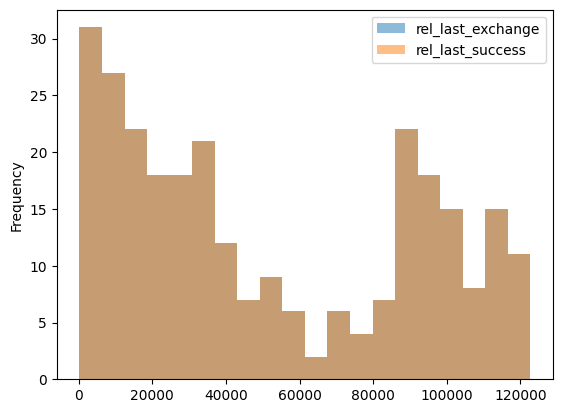

In [20]:
df.plot.hist(bins=20, alpha=0.5)

In [21]:
df[df.rel_last_exchange < 24*3600]

,rel_last_exchange,rel_last_success,handle
0,55975.199161,55975.199161,krill_publisher_674190894927
2,14639.199161,14639.199161,krill_publisher_603985408889
3,1830.199161,1830.199161,krill_publisher_809090195649
5,13203.199161,13203.199161,krill_publisher_746616548133
6,71645.199161,71645.199161,krill_publisher_318351530302
...,...,...,...
273,25348.199161,25348.199161,krill_publisher_335644505148
274,25274.199161,25274.199161,krill_publisher_378089449302
276,5895.199161,5895.199161,krill_publisher_519703114561
277,21144.199161,21144.199161,krill_publisher_634900463955


In [22]:
"""
Get the status of all krill CAs
"""
async with KrillApiClient(KRILL_URL, TOKEN, aiohttp.Fingerprint(digest)) as client:
    t0 = time.time()

    res = await client.list()
    
    t1 = time.time()
    
    statuses = await asyncio.gather(*[
        client.ca_status(r.handle)
        for r in res
    ])
    
    t2 = time.time()
    
LOG.info(f"Loaded a list of %d CAs in %.3fs. Loaded %d CA statuses in %.3fs", len(res), t1-t0, len(statuses), t2-t1)


INFO:__main__:Loaded a list of 279 CAs in 0.520s. Loaded 279 CA statuses in 8.287s


In [23]:
"""
Delete CAs without repo info
"""
async with KrillApiClient(KRILL_URL, TOKEN, aiohttp.Fingerprint(digest)) as client:
    deleted = 0
    failed = 0
    for s in statuses:
        if s.repo_info is None:
            try:
                await client.ca_delete(s.handle)
                deleted += 1
            except KrillApiError as e:
                failed += 1
    LOG.info("Deleted %d CAs without repository configured [%d failures].", deleted, failed)

INFO:__main__:Deleted 0 CAs without repository configured [0 failures].
